In [ ]:
# cd aiffel
# git clone https://github.com/airobotlab/KoChatGPT

# Base model and Dataset for RLHF


FLAN의 Instruction Tuning이나 PaLM의 Prompt Engineering 이 효과를 보기 위해선
언어모델의 입력을 단순한 query 형태로 주기보단 정교한 입력 시퀀스를 설계해야 한다.
그리고 긴 prompt를 입력할 수 있으려면 그만한 모델 capacity가 뒷받침 되어야 합니다.

In [1]:
# Backbone Network : KoGPT-2
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
tokenizer.max_model_input_sizes

{'gpt2': 1024,
 'gpt2-medium': 1024,
 'gpt2-large': 1024,
 'gpt2-xl': 1024,
 'distilgpt2': 1024}

In [63]:
print(tokenizer.vocab_size)

51200


In [65]:
input_txt = "광화문에서 남산 가는법 알려줘."
tokens = tokenizer(input_txt).tokens()
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].numpy()

In [69]:
print(tokens)
print(input_ids[0])

['▁광', '화', '문에서', '▁남산', '▁가는', '법', '▁알려', '줘', '.']
[ 9296  8756 14608 18350 11318  7627  9666  8244   389]


In [10]:
pd.options.display.max_columns = 40
pd.options.display.max_rows = 60
df = pd.DataFrame([tokens, input_ids[0]], index=["kogpt-2_tokens", "Input_IDs"])
df

,0,1,2,3,4,5,6,7,8,9
kogpt-2_tokens,▁광,화,문에서,▁수원,역에,가는,▁길,▁알려,줘,.
Input_IDs,"tensor(9296, device='cuda:0')","tensor(8756, device='cuda:0')","tensor(14608, device='cuda:0')","tensor(17425, device='cuda:0')","tensor(11659, device='cuda:0')","tensor(9932, device='cuda:0')","tensor(9367, device='cuda:0')","tensor(9666, device='cuda:0')","tensor(8244, device='cuda:0')","tensor(389, device='cuda:0')"


In [11]:
# 디코딩 성능 확인
max_length=128
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
# do_sample : sample decoding
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

광화문에서 수원역에가는 길 알려줘.</d> #20180712 #미롱_식단 <unk>
<unk><unk>점심 : #닭가슴살 #닭가슴살샐러드
<unk><unk>저녁 : #닭가슴살샐러드
<unk><unk>저녁 : #닭가슴살샐러드
<unk><unk>저녁 : #닭가슴살샐러드
<unk><unk>저녁 : #닭가슴살샐러드
<unk><unk>저녁 : #닭가슴살샐러드
<unk><unk>저녁 : #닭가슴살샐러드
<unk><unk>저녁 : #닭가슴살샐


< 시퀀스가 반복은 그리디 서치 디코딩시 발견되는 전형적인 현상 >
> why? 그리디(가장 확률이 높은 단어 선택)이 반복 선택되므로, 특정 단어나 패턴이 반복

In [71]:
# # 빔 서치 디코딩을 사용하고 n-gram 패널티까지 부과
output_beam = model.generate(input_ids, max_length=max_length, num_beams=10, no_repeat_ngram_size=2,
                             do_sample=False)
print(tokenizer.decode(output_beam[0]))

입력 시퀀스와 별 상관 없어 보이는 긴 문단이 생성됩니다.
그럼에도 생성된 문단은 제법 맥락을 갖춘 듯 보입니다.
하지만 문장 간의 정합성이나 일관성은 다소 떨어지는 부분도 관찰됩니다.
이번엔 샘플링 기법까지 추가해 보겠습니다.
> why? no_repeat_ngram_size=2 옵션을 사용하면 2-gram이 반복되지 않도록 강제되므로, 그리고 Beam Search는 확률적으로 최적의 단어를 선택하지, 전체 문맥을 고려하진 않음

In [13]:
# top_k샘플링 기법
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, temperature=2.0, top_k=50)
print(tokenizer.decode(output_beam[0]))

광화문에서 수원역에가는 길 알려줘. 아~ 맞아.
너무 재밌는 거 같애. <unk>가 어~ 약간 어색한 느낌도 있고 네. 약간 섹시하지 않나?
어~ 그런 느낌이 좀 있긴 하긴 해요.
네. 그쵸? 아니.
그렇다고 괜찮아?
이런 생각도 든다고?
응응. 그럴 수도 있겠다.
그럼? 어.
아~ 그건 그거야? 근데 좀 그런 느낌은 있어.
예. 그렇구나.
한번쯤은 봤을 거라고.
이렇게 생각 안 해본 적이 없어.



In [14]:
# top_p 샘플링 기법
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, top_p=0.90)
print(tokenizer.decode(output_beam[0]))

광화문에서 수원역에가는 길 알려줘. ᄏᄏ
수원역에서 수원역까지 가는 버스를 타면 수원역으로 갈 수 있어요~
경기도 수원시 팔달구 인계동 311-1
전화번호 : 031-245-0060
영업시간 : 매일 11:00 - 22:30
주차: 평일 오전 10시~오후 6시
일요일 휴무 ^^ 
수원역 1번 출구로 나와서 오른쪽으로 가면 수원역이 보이더라구요!
수원역에 도착하면 수원역과 수원역을 잇는 버스정류장이 있답니다! ᄒᄒ



> 최선의 디코딩 방법을 찾기 위해선 빔사이즈와 n-gram 패널티, temperature와 샘플링 인자로
조합할 수 있는 최선의 값을 찾아보는 실험이 필요

### 데이터셋 확인





In [72]:
#kochatgpt_1_SFT 데이터셋
import json 
data_path_1_SFT = '/aiffel/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '불고기용 고기 한우에요?',
  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
  'tokens': 193},
 {'prompt': '쓰던 앱이 유료로 전환됐어',
  'completion': "'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.",
  'tokens': 288},
 {'prompt': '여친이랑 다툼',
  'completion': "'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다. 논리적이고 차분한 대화를 통해 문제를 해결해보세요. 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다.",
  'tokens': 153}]

In [16]:
#다음으로 RM에 사용할 데이터셋을 살펴보겠습니다.
data_path_2_RM = '/aiffel/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl'
with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

10220


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?',
  'completion_0': 'Allow me to answer your question. I know that you are curious about me.',
  'completion_1': '번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.',
  'completion_2': '라이언에게 말했다.',
  'ranking': [2, 1, 0]},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?',
  'completion_0': '개포주공아파트는 다섯 단지로 이루어져 있습니다.',
  'completion_1': '이날 목송에서 구글상위노',
  'completion_2': '개포주공아파트는 총 27개 단지로 이루어져 있습니다.',
  'ranking': [2, 0, 1]},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?',
  'completion_0': 'The diameter of the Metallic domain is bigger than the Hyperonic domain.',
  'completion_1': '이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가 그 발언을 문제삼았는지에 따라 답이 다를 수 있습니다.\\n\\n만약 김영삼 대통령이 후보 시절에 지역표심을 겨냥한 발언을 했다는 가정하에, 그 발언을 문제삼은 후보가 누구였는지를 대답하자면, 그 답은 이화선 당시 민주당 대통령 후보가 될 것입니다. 1992년 총선 때, 김영삼 대선후보는 "집값이 오른 노량진역 부근의 부동산 가격은 세월호 폭침 후 \\\'강남 도시재생\\\' 일환으로 상승했다"는 발언을 했습니다. 하지만 이화선 후보는 이 발언을 "전국적으로 경제적 발전이 이루어지지 않은 지방민의 마음을 멀리해지려는 무례한 발언"이라고 비판하며 문

In [17]:
# PPO 학습에 쓰일 데이터
data_path_3_PPO = '/aiffel/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl'
with open(data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?'},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?'},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?'}]

# TODO: EDA

In [ ]:
########################################

In [85]:
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    
df = pd.DataFrame(list_data_dict)
print(df.shape)
df[:5]

(12000, 3)


,prompt,completion,tokens
0,불고기용 고기 한우에요?,"'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하...",193
1,쓰던 앱이 유료로 전환됐어,"'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 ...",288
2,여친이랑 다툼,'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하...,153
3,술 먹고 싶어,"'술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 ...",189
4,잊고싶다.,'저도 인공지능 엔진으로써 사용자의 개인정보나 감정을 침해할 수 없습니다. 그렇기 ...,147


In [ ]:
########################################

# Supervised Fine-Tuning


In [18]:
#kogpt-2를 instruction dataset으로 SFT

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

In [19]:
#모델과 토크나이저 setting
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [20]:
# 모델 인퍼런스 단계에서 사용할 prompt 딕셔너리 템플릿과 SFT 데이터셋 클래스를 정의

from typing import Optional, Dict, Sequence

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        #SFT의 입력과 정답이 동일한 경우
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        # input_ids_lens와 labels_lens는 각 문서에서 패딩을 제외한 유효한 토큰의 개수
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

    
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [21]:
train_dataset = SFT_dataset(data_path_1_SFT='/aiffel/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([  739,   378,   378,   378, 14659, 13394, 37091, 10651,   383, 25841,
         8006, 14914,   375,  7673, 20479,  8091, 22311,  9036, 30902, 13675,
          375,   378,   378,   378, 41951,   454,  9549, 20549,   383,  8142,
         7192, 14914,   382, 37767, 13753,  8263,  7166,   739,  8352,  7659,
         9594, 25585, 13600,  8022,  9378, 11532,  9887, 11218,  9111, 16691,
        10351, 10561,  9128, 20479,  8091,  9065,  9446,  9036, 28420, 26521,
        10163, 26367,  6958,  9030,  9882, 12317, 25882,  9209, 37194, 10351,
         9036, 12168, 10529, 15989,  9719, 15434, 10552, 11188, 13362,  9036,
        15805, 11300, 11846,  9146, 16691,  9181,  7397, 15806, 13480, 11342,
        17596,  9161, 19996,  9025, 25006, 18595,  9966, 12592, 10751, 11814,
         8711,  9046, 12450,  9117,  7377, 12521,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -10

In [22]:
# train_dataset.input_ids[0]를 디코딩해보세요.
text = tokenizer.decode(train_dataset.input_ids[0])
print(text)

### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.</s>


In [23]:
#  Training arguments를 사용해 trainer 클래스를 정의

training_args = TrainingArguments(
    output_dir="/aiffel/KoChatGPT/test",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [24]:
# SFT 훈련을 진행해볼까요? (빠르게 학습해보기 위해 1epoch만 돌려보도록 하겠습니다.)
trainer.train()
model.save_pretrained('/KoChatGPT/output_1_SFT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,3.149500
1000,2.947900
1500,2.875000
2000,2.759300
2500,2.742400
3000,2.656700


In [64]:
torch.cuda.empty_cache()

# Reward Model


In [80]:
os.getcwd()

'/aiffel/aiffel'

In [87]:
# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'chatgpt')))

In [25]:
import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

In [27]:
#reward model
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

In [28]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)
# chatgpt/trainer/strategies 폴더의 base 모듈에서 정의된 Strategy클래스를 상속한 NaiveStrategy클래스
with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
# RM을 훈련시킬 때 사용할 ranking dataset

# kochatgpt_2_RM.jsonl: chatGPT, davinch, ada 세개 모델에 같은 prompt를 주고 얻은 세 답변

with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])


before data num: 10220
after  data num: 30660
data example: 
{'prompt': '애플은 리사를 어떻게 처리했어', 'chosen': '애플이 누구인지 명확히 알 수 없어서, 리사가 누구인지와 어떤 상황에서 처리되었는지에 대한 추가적인 정보가 필요합니다. 따라서, 보다 정확한 답변을 제공할 수 없습니다.', 'rejected': '애플은 리사를 위해 고객 서비스 부서에서 고객 다양한 컴퓨터 관련 문제에 대해 응답하는 데 필요한 모든 지원을 제공했습니다. 사용자가 하드웨어 문제를 경험할 때, 전문가들은 필요한 수리(수리, 추가 부품 제공, 소프트웨어 업그레이드 등)을 제공해 드릴 수 있습니다. 또한, 사용자가 사용 방법 문제나 기타 문제를 경험할 때, 대화 상대로 사용자를 지원할 수 있는 전문 고객 서비스 직원들이 사용자에게 상담하고 도움을 주는 데 도움이 될 수 있는 정보를 제공합니다. 또한, 인터넷에서 제공되는 정보를 통해 문제를 해결하거나 고객 서비스 웹 사이트를 통해 자신의 문제를 진단할 수 있도록 하는 등 다양한 방법으로 리사를 처리해 왔습니다.'}


In [33]:
#  ranking dataset을 shuffle한 후 훈련셋을 만들기 
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

1000
200


100%|██████████| 200/200 [00:00<00:00, 1013.31it/s]


In [34]:
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

######################################################################
## prompt ##
번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?
######################################################################
## chosen ##
라이언에게 말했다.
######################################################################
## rejected ##
Allow me to answer your question. I know that you are curious about me.


In [35]:
# RM을 학습
'''
많은 자원이 소모됩니다.
모델 체크포인트를 활용할 수 있으니, 각각의 모델을 더 많은 데이터로 더 오래 훈련하고자 할 시,
커널을 초기화 한 후 재학습을 해보세요.
'''

trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

trainer.fit(use_lora=0)

model.save_pretrained('aiffel/KoChatGPT/output_2_RM')

Train step of epoch 0:  38%|███▊      | 94/250 [01:22<02:20,  1.11it/s, loss=0.713]


Train step of epoch 0:  75%|███████▍  | 187/250 [02:45<00:56,  1.12it/s, loss=0.412]


Train epoch: 100%|██████████| 1/1 [03:56<00:00, 236.02s/it]


In [36]:
'''
RM 학습이 잘 되었는지 확인해보기 위해 임의의 문장을 입력한 후
적절한 reward score를 출력하는지 살펴보도록 하겠습니다.

'''
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

In [45]:
input_text = '인공지능'
output_reward = inference_RM(input_text=input_text)

input: 인공지능
reward score: 1.7


In [38]:
input_text = "인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다.
reward score: 1.7


- reward score가 음수가 된다는 건 어떤 의미일까요?   
- 그 전에 reward score가 음수도 될 수 있도록 하려면 어떻게 해야 할까요?   
- RM의 출력인 reward score가 scalar가 되도록 하는 게 왜 중요할까요?   
> why?

# Proximal Policy Optimization

PPO에 사용할 actor모델은 1단계 SFT 모델을, critic모델은 2단계 RM 모델을 사용합니다.  
그리고 actor 모델이 critic 모델로부터 피드백을 받아 파라미터를 업데이트 할 때
적절한 페널티를 줄 수 있도록 하는 initial model은
SFT모델을 그대로 freezing 하여 사용합니다. ( pretrain모델의 kogpt-2의 토크나이저 ) 

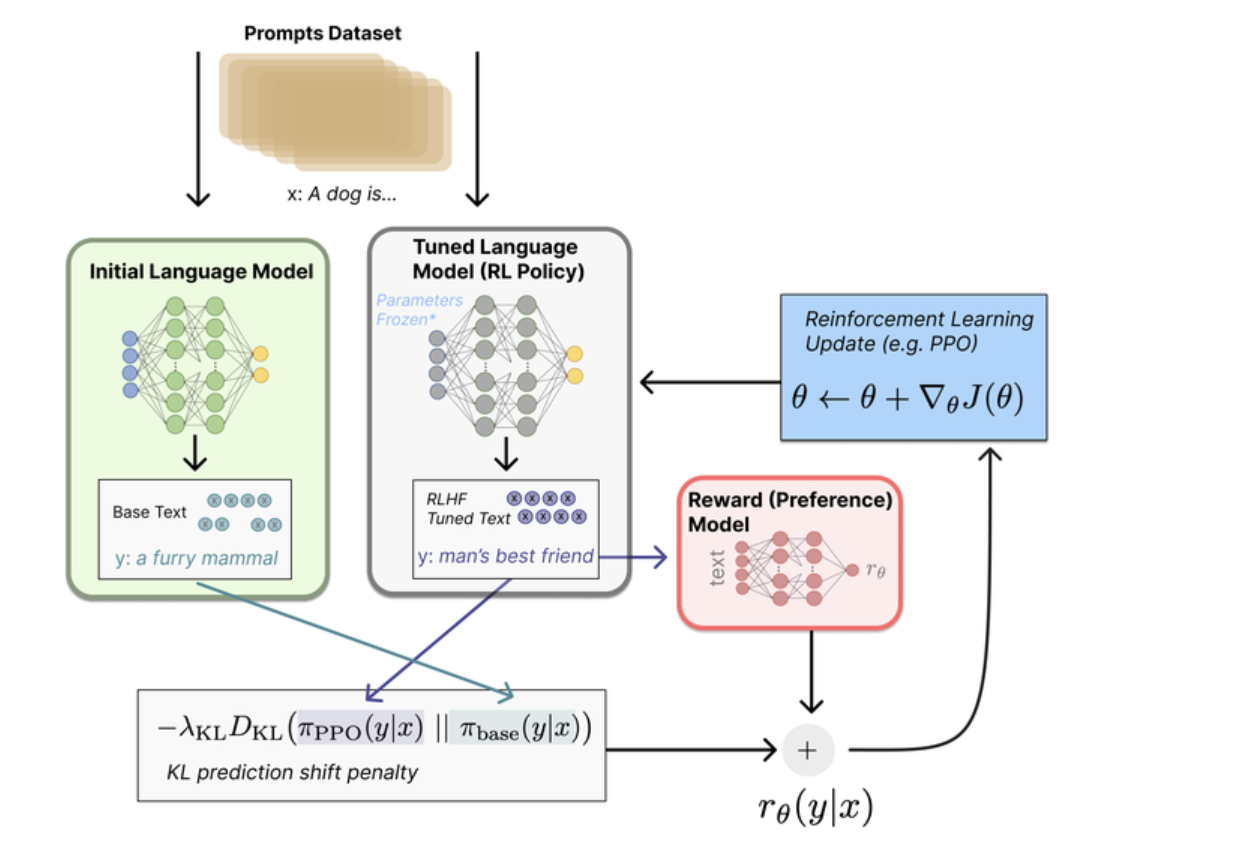

In [46]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

In [52]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='/KoChatGPT/output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='aiffel/KoChatGPT/output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

In [54]:
#학습에 사용할 옵티마이저와 모델
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare((actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

In [55]:
# PPO 학습에 쓸 데이터를 불러와 토크나이징
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [56]:
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

{'input_ids': tensor([[47311, 10448, 19008,  9792, 11780, 11308, 30190, 10929, 11849, 21663,
         44389,  9574, 13799,   458, 14308, 12778, 22469, 20938, 44696,   458,
         13799,   458, 14308, 12778, 11756, 18944,   389]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}


In [58]:
# PPO는 별도의 PPOTrainer 클래스를 설계하여 학습
'''
 원본 코드는 chatgpt/trainer 폴더 내의 ppo.py 
 
 PPO의 loss function은 chatgpt/models 폴더 내의 loss.py 모듈에서
 PolicyLoss와 ValueLoss 클래스에 정의되어 있습니다.
'''
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

In [59]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('aiffel/KoChatGPT/output_3_PPO')

Episode [10/10]: 100%|██████████| 3/3 [00:18<00:00,  6.00s/it]


In [60]:
# RLHF가 적용된 koGPT-2의 생성능력을 확인
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 AI 언어 모델이므로 한우 쇠고기용 한우에 대해 알려드릴 수 없습니다. 하지만 일반적으로 쇠고기는 쇠고기의 소고기가 먹던 종류 중 하나이며, 쇠고기가 들어간 경우가 많아서 한우에 대해서는 더 자세한 정보가 필요합니다. 또한 쇠고기에 대해서는 쇠고기를 제외한 다른 부위에도 한우가 들어갈 수 있습니다. 따라서 쇠고기가 들어가는 한우와 고기는 각각의 고기마다 다른 특징을 가지고 있을 것입니다. 문맥상 불고기용 한우는 한우와 고기의 종류 중 하나입니다.  \: - \ \n\n2.  \n\n한우는 쇠고기 (불고기용)  \n\n한우는 쇠고기의 종류와의 유사성입니다. 따라서 한우와 고기의 종류 중 하나는 한우입니다.  \n\n3. \n한우는 쇠고기고기의 종류 중 하나이기 때문에, 한우의 경우는 쇠고기고기의 종류 중 하나입니다.  \n\n하지만, 일반적으로 쇠고기는 고기 중에서도 주로

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨이 43대 부통령직을 수행한 년도는 1947년입니다. Leee science and the English cups of the phrase collection of quest. therefore translation of dividender referring on the statements of the phrase of translation. quest of because wellet here never waiting offects of the statements of the diversity to refility or denique and soft had and give of the they family? quest for ques of the service of the phrase in English. quest of statement to buildin

==============   
중복 토큰 생성 문제를 비롯해 맥락에서 벗어난 한문이나 영문이 출력되기도 합니다.
kogpt-2에 SFT만 적용했을 때와 비교해보면 큰 차이를 느끼지 못할 수도 있습니다.
각 단계에서 사용되는 데이터셋을 충분히 정제하고, 훈련 사이클을 늘려 정교하게 디코딩한다면
훨씬 나은 성능을 기대해볼 수 있습니다.

RLHF의 진가는 고도로 정제된 instruction dataset와 정교하게 설계된 보상체계로 학습되는 Reward model,
그리고 PPO 학습이 안정적으로 이뤄질 수 있도록 하는 충분한 크기의 foundation model이 뒷받침 되었을 때 발휘될 수 있습니다.

In [87]:
### 해볼만한 것
### 1. Generator HP tuning
### 2. Reward Model 변경 (가장 높은 reward에 가중치를 더 줌)
### 3. Metrics

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.9/site-packages/pandas/core/indexes/base.py:3361 in get_loc               │
│                                                                                                  │
│   3358 │   │   │   │   )                                                                         │
│   3359 │   │   │   casted_key = self._maybe_cast_indexer(key)                                    │
│   3360 │   │   │   try:                                                                          │
│ ❱ 3361 │   │   │   │   return self._engine.get_loc(casted_key)                                   │
│   3362 │   │   │   except KeyError as err:                                                       │
│   3363 │   │   │   │   raise KeyError(key) from err                                              │
│   3364                                                                                           │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:76                                                     │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:108                                                    │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:5198                                        │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:5206                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'completion_aug'

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│   3 def compute_bleu(reference, hypothesis):                                                     │
│   4 │   return sentence_bleu([reference.split()], hypothesis.split())                            │
│   5                                                                                              │
│ ❱ 6 bleu_scores = [compute_bleu(ref, hyp) for ref, hyp in zip(df["completion"], df["completi     │
│   7 print(f"BLEU Score: {sum(bleu_scores)/len(bleu_scores):.4f}")                                │
│   8                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3458 in __getitem__                  │
│                                                                                                  │
│    3455 │   │   if is_single_key:                                                                │
│    3456 │   │   │   if self.columns.nlevels > 1:                                                 │
│    3457 │   │   │   │   return self._getitem_multilevel(key)                                     │
│ ❱  3458 │   │   │   indexer = self.columns.get_loc(key)                                          │
│    3459 │   │   │   if is_integer(indexer):                                                      │
│    3460 │   │   │   │   indexer = [indexer]                                                      │
│    3461 │   │   else:                                                                            │
│                                                               